![](https://i.pinimg.com/564x/77/c7/64/77c764e1334a948856e70490cb0d7110.jpg)

# Accelerometer Calibration

Although accelerometers come from the factory calibrated to a rough level for drop detection or car impact detection, this calibration is not sufficient for inerital navigation. Here we are going to follow the AN4508 application note on how to calibrate an accelerometer using least squares.

Following Table 1, we are going to collect measurements in the following 6 orienations:

- x up/down
- y up/down
- z up/down

Then rely on least squares ($Ax=B$) to calculate the misalignments and offsets to recover the *true* measurements. `numpy.linalg.lstsq()` return the least-squares solution to a linear matrix equation.Solves the equation a x = b by computing a vector x that minimizes the Euclidean L2-norm ($|| b – a x ||^2$). 

## References

- AN4508: [Parameters and calibration of a low-g 3-axis accelerometer](AN4508.pdf)
- Vectornav: [Accelerometer](https://www.vectornav.com/support/library/accelerometer)
- [Least squares fitting with Numpy and Scipy](https://mmas.github.io/least-squares-fitting-numpy-scipy)
- GeeksforGeeks: [Numpy Linear Algebra](https://www.geeksforgeeks.org/numpy-linear-algebra/)
- Wikipedia: [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance)
- Oxford Reference: [International Gravity Formula](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803100007626)

## Accelerometer Model

We can view the sensor model as a the transformation of the *true* acceleration measurement ($\vec{a}$) morphed into a noisy measurement ($\vec{am}$) due to misalignments, biases (offsets), etc. Mathematically it is:

$$
\begin{align*}
\vec{a} &= \mathbf{M} \mathbf{S} (\vec{am} - \vec{b}) \\
\begin{bmatrix}
a_x \\ a_y \\ a_z
\end{bmatrix} &= 
\begin{bmatrix}
1 & M_{xy} & M_{xz} \\
M_{yx} & 1 & M_{yz} \\
M_{zx} & M_{zy} & 1
\end{bmatrix}
\begin{bmatrix}
\frac{1}{S_x} & 0 & 0\\
0 & \frac{1}{S_y} & 0\\
0 & 0 & \frac{1}{S_z}
\end{bmatrix}
\begin{bmatrix}
am_x - b_x \\ am_y - b_y \\ am_z - b_z
\end{bmatrix} 
\end{align*}
$$

where $\mathbf{M}$ is cross coupling due to non-orthogonal sensor axes created during senors construction, $\mathbf{S}$ is sensitivity errors, and $\vec{b}$ are constant bias offsets. Now we can solve and get the *true* acceleration, but then we are going to put it into a form for least squares that looks like $Ax=B$. First we need to do a little rearranging:

$$
\begin{align*}
\vec{a} &= \mathbf{M} \mathbf{S} \vec{am} + \mathbf{M} \mathbf{S} \vec{b} \\
\vec{a} &= [\mathbf{M} \mathbf{S} | \vec{b}]_{3x4}
\begin{bmatrix}
am_x & am_y & am_z & 1
\end{bmatrix}^T \\
\vec{a} &=[\vec{am} | 1] [\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}\\
B &= A_{1x4} [x]_{4x3}
\end{align*}
$$

where $[\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}$ is a constant matrix of correction coefficients. Now, for least squares, $A$ becomes our noisy measurements and $B$ is our ideal states. In order to clean up our noisy measurements, we just post-multiply by our $x$ matrix (which least squares finds). So for $n$ samples, our solution becomes:

$$
\begin{align*}
\vec{a}_{nx3} &= [\vec{am} | 1]_{nx4} [\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}\\
B &= A_{nx4} [x]_{4x3}
\end{align*}
$$

where $B$ is $\begin{bmatrix} 0 & 0 & g \end{bmatrix}^T_{nx3}$ for z-axis up and $\begin{bmatrix} 0 & 0 & -g \end{bmatrix}^T_{nx3}$ for z-axis down. 

# Calibrate

In [169]:
import numpy as np # matrix manipulations
import os
from scipy import linalg

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Pickle, Json

from squaternion import Quaternion

import pandas as pd
from glob import glob

%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt

# from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg
from math import pi, sin, sqrt

from slurm import storage

from datetime import datetime

the-collector: 0.8.7


## Gravity Model

Gravity is not constant everywhere. Due to the shape of the Earth, the gravity changes based on altitude (the higher you go, the smaller it is) and the latitude you are located.

In [170]:
gps_lat = 38.785809

In [176]:
def gravity(lat):
    """Based off the Oxford reference for the gravity formula at sealevel.
    
    lat: latitude in degrees
    """
    lat *= pi/180
    return 9.78*(1 + 0.0053024*sin(lat)**2 - 0.0000058*sin(2*lat)**2)

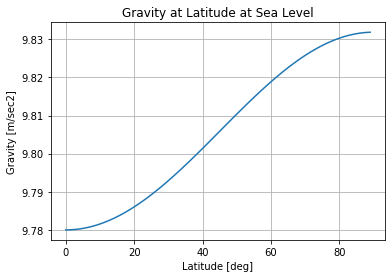

In [177]:
plt.plot(range(90), [gravity(x) for x in range(90)])
plt.ylabel("Gravity [m/sec2]")
plt.xlabel("Latitude [deg]")
plt.title("Gravity at Latitude at Sea Level")
plt.grid(True)
plt.show();

## Data

In [175]:
!ls ~/github/data-ins-1/2020-5-3-imu/*.bag

/Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag


In [50]:
tmp = "/Users/kevin/github/data-ins-1/2020-5-3-imu/still-*.pickle.bag"
files = glob(tmp)
len(files)

6

In [51]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

bag = BagIt(Pickle)

data = bag.read(files[0])
bag_info(data)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 2001   
         mag: 2001   
        gyro: 2001   


In [55]:
def get_np(bag, key, one=False):
    """
    bag: data dictionary
    key: dict key
    one: change vector from [1,3] to [1,4]
    """
    d = []
    for v,ts in bag[key]:
        if one: d.append(v + (1,))
        else: d.append(v)
    return np.array(d)

def get_data(fname, key, one=True):
    """
    fname: bag file name to open
    key: dict key
    one: change vector from [1,3] to [1,4]
    """
    bag = BagIt(Pickle)
    data = bag.read(fname)
    return get_np(data, key, one)

def get_ideal(orient, num):
    g = gravity(gps_lat)
    if orient == "x-up":
        nn=np.array([g,0,0]*num).reshape(num,3)
    elif orient == "x-down":
        nn=np.array([-g,0,0]*num).reshape(num,3)
    elif orient == "y-up":
        nn=np.array([0,g,0]*num).reshape(num,3)
    elif orient == "y-down":
        nn=np.array([0,-g,0]*num).reshape(num,3)
    elif orient == "z-up":
        nn=np.array([0,0,g]*num).reshape(num,3)
    elif orient == "z-down":
        nn=np.array([0,0,-g]*num).reshape(num,3)
    else:
        raise Exception("Invalid orientation")
        
    return nn 

In [61]:
template = "/Users/kevin/github/data-ins-1/2020-5-3-imu/still-{}.pickle.bag"

noisy = None
ideal = None

for x in ["x-up", "x-down", "y-up", "y-down", "z-up", "z-down"]:
    d = get_data(template.format(x), "accel")
    if noisy is None:
        noisy = d
        ideal = get_ideal(x, d.shape[0])
    else:
        noisy = np.append(noisy, d,0)
        ideal = np.append(ideal, get_ideal(x, d.shape[0]),0)

print("Noisey", noisy.shape)
print("Ideal", ideal.shape)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag
Noisey (12006, 4)
Ideal (12006, 3)


# Calibration

In [62]:
def least_squares_fit(A, B):
    """B = A*x which is: ideal = noisy*x => [n,3] = [n,4][4,3]
    ideal = [n,3] = [x,y,z]
    noisy = [n,4] = [x,y,z,1]: the 1 accounts for the biases
    A = [4,3]: this is a bunch of coefficient matrices [[S],[H]]
      S = [3,3] 
      H = [1,3] 
    """
    # Need to extend A and B
    # A = np.hstack((A, np.ones(len(A)).reshape(-1, 1)))
    # print(A)

    X, res, rank, s = np.linalg.lstsq(A, B, rcond=None)
    print(f"Rank: {rank}")
    print(f"Singular values: {s}")
    print(f"Sum residual error: {np.sum(res)}")
    return X

In [63]:
xx = least_squares_fit(noisy, ideal)
print("--------------------------------")
print(xx)

Rank: 4
Singular values: [632.44137865 606.93315748 603.91134494 108.37913904]
Sum residual error: 122.66872415727146
--------------------------------
[[ 1.02400092e+00 -3.45261585e-02 -1.01769491e-03]
 [ 4.23077341e-02  9.98467945e-01  3.35023613e-02]
 [-8.15357803e-03 -2.30023797e-03  1.01483354e+00]
 [-2.25789932e-01  3.89400169e-01 -6.95899235e-01]]


In [64]:
print(noisy[1,:])
try:
    print(noisy[1,:].dot(xx[:3,:3]) + xx[3,:])
except:
    print(noisy[1,:].dot(xx))

[ 9.79860306 -0.03828515  0.73698902  1.        ]
[9.80035979 0.0111703  0.04076731]


In [185]:
def plot(fname, key, xx=None):
    if xx is None:
        n = get_data(fname, key, False)
    else: 
        n = get_data(fname, key)
        n = n.dot(xx)
    c = pd.DataFrame(n, columns=["x","y","z"])
    cx,cy,cz = c.mean()
    csx,csy,csz = 1000*c.std()
    cm = (cx**2 + cy**2 + cz**2)**0.5
    
    if key == "accel":
        title=f"$\mu$: ({cx:.2f},{cy:.2f},{cz:.2f})m/sec2;  $\sigma$: ({csx:.0f},{csy:.0f},{csz:.0f})mm/sec2"
    else:
        title=f"$\mu$: ({cx:.2f},{cy:.2f},{cz:.2f})dps;  $\sigma$: ({csx:.0f},{csy:.0f},{csz:.0f})mdps; |$\mu$|: {cm:.4f}dps"
    c.plot(
        subplots=True, 
        grid=True, 
        title=title);

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag


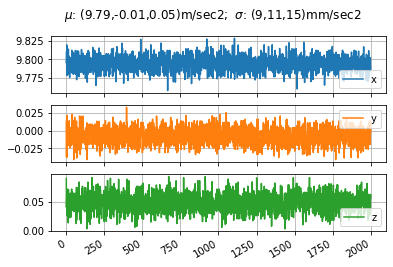

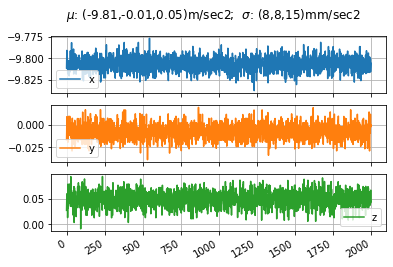

In [186]:
plot(template.format("x-up"),"accel", xx)
plot(template.format("x-down"),"accel",xx)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag


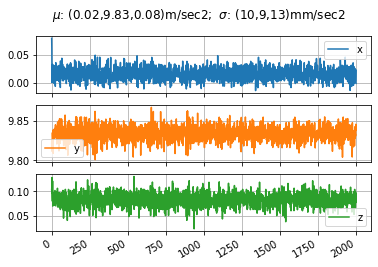

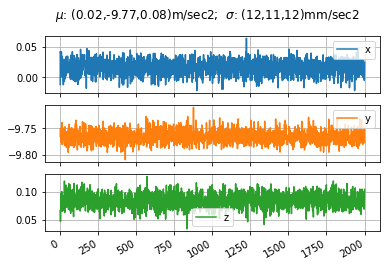

In [141]:
plot(template.format("y-up"),"accel",xx)
plot(template.format("y-down"),"accel",xx)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag


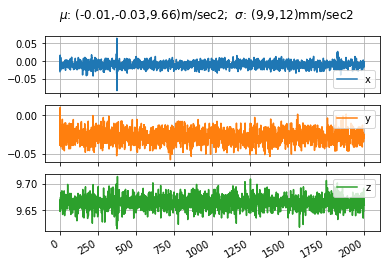

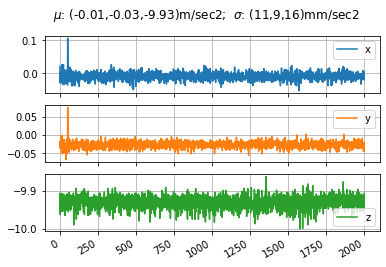

In [142]:
plot(template.format("z-up"),"accel",xx)
plot(template.format("z-down"),"accel",xx)

# Gyros

The gyros will follow a simpler method. Basically, when all of this data was taken, the IMU was stationary, hence, all values should be zero. So we are going to find the best bias values to compensate.

Ideally, we would spin the gyros around all 6 orientations at a known speed and gather data to use in a least squared solution. Unfortunatly, I do not have the equipment to test that way.

In [178]:
gnoisy = None
gideal = None

for x in ["x-up", "x-down", "y-up", "y-down", "z-up", "z-down"]:
    d = get_data(template.format(x), "gyro")
    if gnoisy is None:
        gnoisy = d
    else:
        gnoisy = np.append(gnoisy, d,0)

gideal = 0.01*np.zeros((gnoisy.shape[0],3))

print(gnoisy.shape)
print(gideal.shape)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag
(12006, 4)
(12006, 3)


>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag


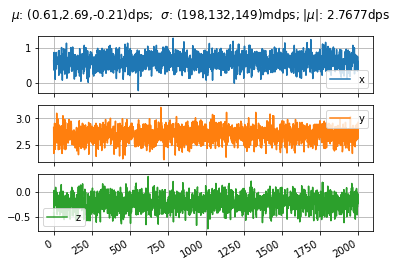

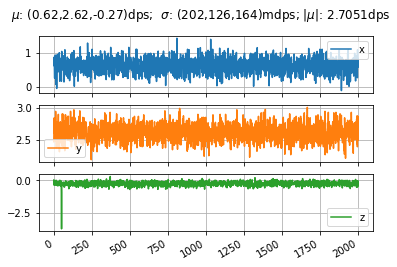

In [187]:
# let's look at the raw data to get a starting point for the biases
plot(template.format("z-up"),"gyro")
plot(template.format("z-down"),"gyro")

[[ 1.    0.    0.  ]
 [ 0.    1.    0.  ]
 [ 0.    0.    1.  ]
 [-0.61 -2.69  0.21]]
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag


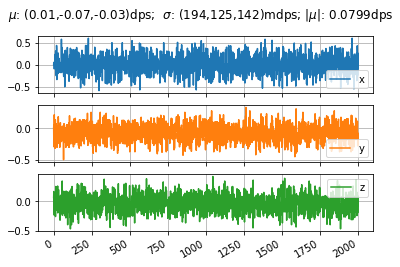

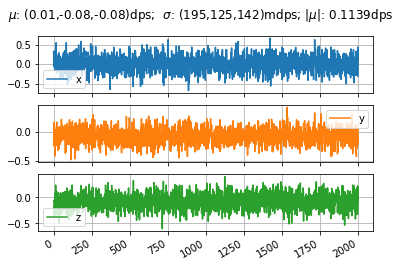

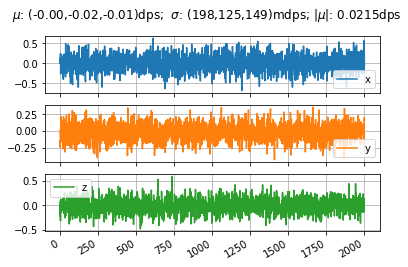

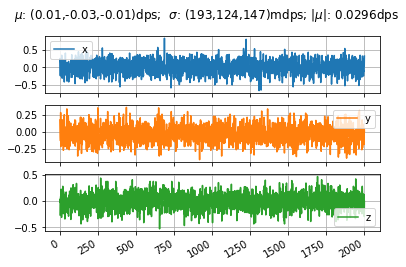

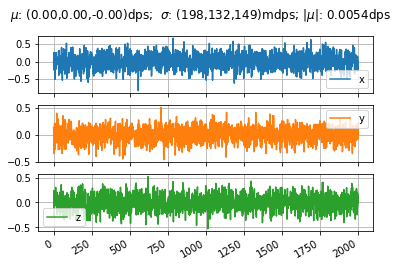

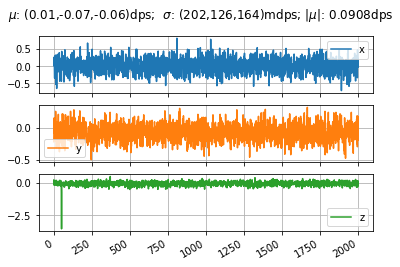

In [188]:
# Now let's see how these work on all 6 orientations
xxx = np.vstack((np.eye(3),np.array([-0.61,-2.69,0.21])))
print(xxx)

for x in ["x-up", "x-down", "y-up", "y-down", "z-up", "z-down"]:
    plot(template.format(x),"gyro",xxx)

# Save Parameters

In [189]:
params = {}
params["imu"] = "Adafruit NXP"
params["timestamp"] = datetime.now()
params["accel"] = {"data": xx.tolist(), "shape": xx.shape, "dtype": str(xx.dtype)}
params["gyro"] = {"data": xxx.tolist(), "shape": xxx.shape, "dtype": str(xxx.dtype)}

In [190]:
storage.write("nxp-accel-gyro.yaml", params)

In [191]:
a = storage.read("nxp-accel-gyro.yaml")
for k,v in a.items():
    if isinstance(v, dict):
        print(f"[{k}]")
        for kk, vv in v.items():
            print(f" => {kk}: {vv}")
    else:
        print(f"[{k}]: {v}")

[accel]
 => data: [[1.0240009233428773, -0.03452615852641119, -0.0010176949138527912], [0.04230773413853203, 0.9984679452877938, 0.03350236131116541], [-0.008153578028445699, -0.0023002379735904688, 1.0148335362180885], [-0.22578993167362213, 0.38940016945933764, -0.695899235450352]]
 => dtype: float64
 => shape: [4, 3]
[gyro]
 => data: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [-0.61, -2.69, 0.21]]
 => dtype: float64
 => shape: [4, 3]
[imu]: Adafruit NXP
[timestamp]: 2020-06-20 22:23:54.940871


In [136]:
# create a numpy array
np.array(a["accel"]["data"])

array([[ 1.02400092e+00, -3.45261585e-02, -1.01769491e-03],
       [ 4.23077341e-02,  9.98467945e-01,  3.35023613e-02],
       [-8.15357803e-03, -2.30023797e-03,  1.01483354e+00],
       [-2.25789932e-01,  3.89400169e-01, -6.95899235e-01]])

In [192]:
# create data type
np.dtype(a["accel"]["dtype"])

dtype('float64')